In [1]:
# import
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
import random
import torch.nn as nn
import torch.nn.functional as F
import warnings
import datetime
from copy import deepcopy

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(999)

In [3]:
#data gen and plot
sns.set()
plt.rcParams['figure.figsize'] = (24, 18)        
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['legend.title_fontsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['font.size'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
dz=5
num = 500 

device = torch.device('cuda')
dataset_x=torch.randn((num,dz))
dataset_y=dataset_x[:,0:1]**2+torch.exp(dataset_x[:,1:2]+
                                        dataset_x[:,2:3]/3)+dataset_x[:,3:4]-dataset_x[:,4:5]+(0.5+dataset_x[:,1:2]**2/2+dataset_x[:,4:5]**2/2)*torch.randn((num,1))


dataset_x=dataset_x.to(device)
dataset_y=dataset_y.to(device)

mean = dataset_y.mean()
std = dataset_y.std()
dataset_y = (dataset_y-mean)/std



In [4]:
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, t):
        out = self.lin(x)
        gamma = self.embed(t)
        out = gamma.view(-1, self.num_out) * out
        return out
class ConditionalGuidedModel(nn.Module):
    def __init__(self, num_steps):
        super().__init__()
        self.lin1 = ConditionalLinear(dz+1, 16, num_steps)
        self.lin2 = ConditionalLinear(16, 16, num_steps)
        self.lin3 = ConditionalLinear(16, 16, num_steps)
        self.lin4 = nn.Linear(16, 1)

    def forward(self, x, y_t, t):
        eps_pred = torch.cat((x, y_t,), dim=1)
        eps_pred = F.softplus(self.lin1(eps_pred, t))
        eps_pred = F.softplus(self.lin2(eps_pred, t))
        eps_pred = F.softplus(self.lin3(eps_pred, t))
        return self.lin4(eps_pred)

In [5]:
num_steps=1000 
def score_loss_fn(model, y_0, x, n_steps,device):
    batch_size = y_0.shape[0]
    t = torch.randint(1, n_steps, size=(batch_size,), device=device) # t_min=1/n_step
    t_input = t.unsqueeze(-1)  # priorly set T=1000/100=10
    t_compute=t.unsqueeze(-1) /100
    epsilon=torch.normal(0,1,(batch_size,1)).to(device)
    y_input=torch.exp(-t_compute/2)*y_0+torch.sqrt(1-torch.exp(-t_compute))*epsilon
    output = model(x, y_input, t_input.squeeze(-1))
    loss=(output+(y_input-torch.exp(-t_compute/2)*y_0)/(1-torch.exp(-t_compute))).square().mean()
    return loss

In [6]:
#train
import datetime
print('training model...')
batch_size=2048
dataloader=torch.utils.data.DataLoader(torch.cat([dataset_x,dataset_y],dim=1),batch_size=batch_size,shuffle=True)
plt.rc('text',color='blue')
model = ConditionalGuidedModel(num_steps).to(device)
lr=1e-2
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
num_epoch = 1500
loss_fn2=nn.MSELoss()
for z in range(num_epoch):
    total_loss=0
    for idx,batch in enumerate (dataloader):
        start = datetime.datetime.now()
        batch_x = batch[:,:dz]
        batch_y = batch[:,dz:]
        loss=score_loss_fn(model, batch_y, batch_x, 1000,device)
        total_loss+=loss
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.)
        optimizer.step()
        end = datetime.datetime.now()
    if z%50==0:
        print(f'{z} epoch,use time:{end-start}, loss:{total_loss} ')

training model...
0 epoch,use time:0:00:00.439999, loss:1.5509213209152222 
50 epoch,use time:0:00:00.004000, loss:0.8490844368934631 
100 epoch,use time:0:00:00.004001, loss:0.4710776209831238 
150 epoch,use time:0:00:00.004000, loss:0.6362730860710144 
200 epoch,use time:0:00:00.004000, loss:0.7777702212333679 
250 epoch,use time:0:00:00.003999, loss:0.526574969291687 
300 epoch,use time:0:00:00.004000, loss:0.26237401366233826 
350 epoch,use time:0:00:00.004001, loss:0.22169238328933716 
400 epoch,use time:0:00:00.004000, loss:0.2731015682220459 
450 epoch,use time:0:00:00.005006, loss:0.36679160594940186 
500 epoch,use time:0:00:00.003000, loss:0.31961923837661743 
550 epoch,use time:0:00:00.004000, loss:0.20809660851955414 
600 epoch,use time:0:00:00.006008, loss:1.1203817129135132 
650 epoch,use time:0:00:00.004000, loss:0.5251172780990601 
700 epoch,use time:0:00:00.004000, loss:1.039373755455017 
750 epoch,use time:0:00:00.004000, loss:0.5082502961158752 
800 epoch,use time:0:0

In [7]:
def score_sampler(model,shape,x, device,sample_steps=1000,):
    model.eval()
    tK_mins_t0=(1000-1)/100 
    delta_t=torch.tensor([tK_mins_t0/sample_steps],device=device) 
    y_k=torch.normal(0,1,(shape)).to(device)
    with torch.no_grad():
        for t in range(1,sample_steps):
            eps=torch.normal(0,(tK_mins_t0/sample_steps)**0.5,(shape)).to(device)
            t_input=torch.tensor([sample_steps-t],device=device)
            y_k=y_k+eps+delta_t*(0.5*y_k+model(x,y_k,t_input)) # t_input from 999 to 1
    return y_k

In [8]:
quantile_005=0.05
quantile_025=0.25
quantile_050=0.50
quantile_075=0.75
quantile_095=0.95
result=[]
repeat=100
num_test=500
for i in range(repeat):
    seed_everything(i+51)
    print(i)
    z_fix=torch.ones(num_test,dz)*torch.normal(0,1,(dz,))
    z_fix=z_fix.to(device)
    y_fix=z_fix[:,0:1]**2+torch.exp(z_fix[:,1:2]+
                                    z_fix[:,2:3]/3)+z_fix[:,3:4]-z_fix[:,4:5]+(0.5+z_fix[:,1:2]**2/2+z_fix[:,4:5]**2/2)*torch.randn((num_test,1)).to(device)
    y_fix=y_fix.to(device)
    y0=score_sampler(model=model,shape=y_fix.shape,x=z_fix, device=device,sample_steps=1000,)
    y_seq=[y0]
    #MSE of quantile
    y_sorted=(mean+std*y_seq[-1]).view(-1).sort().values
    x_sorted=(y_fix).view(-1).sort().values
    mse_005=(y_sorted[round(num_test*quantile_005)]-x_sorted[round(num_test*quantile_005)])**2
    mse_025=(y_sorted[round(num_test*quantile_025)]-x_sorted[round(num_test*quantile_025)])**2
    mse_050=(y_sorted[round(num_test*quantile_050)]-x_sorted[round(num_test*quantile_050)])**2
    mse_075=(y_sorted[round(num_test*quantile_075)]-x_sorted[round(num_test*quantile_075)])**2
    mse_095=(y_sorted[round(num_test*quantile_095)]-x_sorted[round(num_test*quantile_095)])**2
    result.append((mse_005.detach(),mse_025.detach(),mse_050.detach(),mse_075.detach(),mse_095.detach(),mse_005.detach()+mse_025.detach()+mse_050.detach()+mse_075.detach()+mse_095.detach()))
    print(result[-1][-1])

    
quantile_005_mse=0
quantile_025_mse=0
quantile_050_mse=0
quantile_075_mse=0
quantile_095_mse=0
quantile_total=0
for i in result:
    quantile_005_mse+=i[0]
    quantile_025_mse+=i[1]
    quantile_050_mse+=i[2]
    quantile_075_mse+=i[3]
    quantile_095_mse+=i[4]
    quantile_total+=i[5]
    
print(f'result:{quantile_005_mse/repeat,quantile_025_mse/repeat,quantile_050_mse/repeat,quantile_075_mse/repeat,quantile_095_mse/repeat,quantile_total/repeat}')

0
tensor(3.7417, device='cuda:0')
1
tensor(8.7275, device='cuda:0')
2
tensor(5.1860, device='cuda:0')
3
tensor(14.4600, device='cuda:0')
4
tensor(1.2962, device='cuda:0')
5
tensor(0.4633, device='cuda:0')
6
tensor(6.0284, device='cuda:0')
7
tensor(7.9992, device='cuda:0')
8
tensor(4.4551, device='cuda:0')
9
tensor(11.4490, device='cuda:0')
10
tensor(7.0353, device='cuda:0')
11
tensor(2.5201, device='cuda:0')
12
tensor(5.7878, device='cuda:0')
13
tensor(3.9713, device='cuda:0')
14
tensor(1.3692, device='cuda:0')
15
tensor(14.1218, device='cuda:0')
16
tensor(6.9235, device='cuda:0')
17
tensor(10.5419, device='cuda:0')
18
tensor(17.6476, device='cuda:0')
19
tensor(7.8070, device='cuda:0')
20
tensor(4.3365, device='cuda:0')
21
tensor(5.2212, device='cuda:0')
22
tensor(2.5724, device='cuda:0')
23
tensor(7.2296, device='cuda:0')
24
tensor(5.1406, device='cuda:0')
25
tensor(2.7471, device='cuda:0')
26
tensor(4.7350, device='cuda:0')
27
tensor(4.3387, device='cuda:0')
28
tensor(4.0590, device=

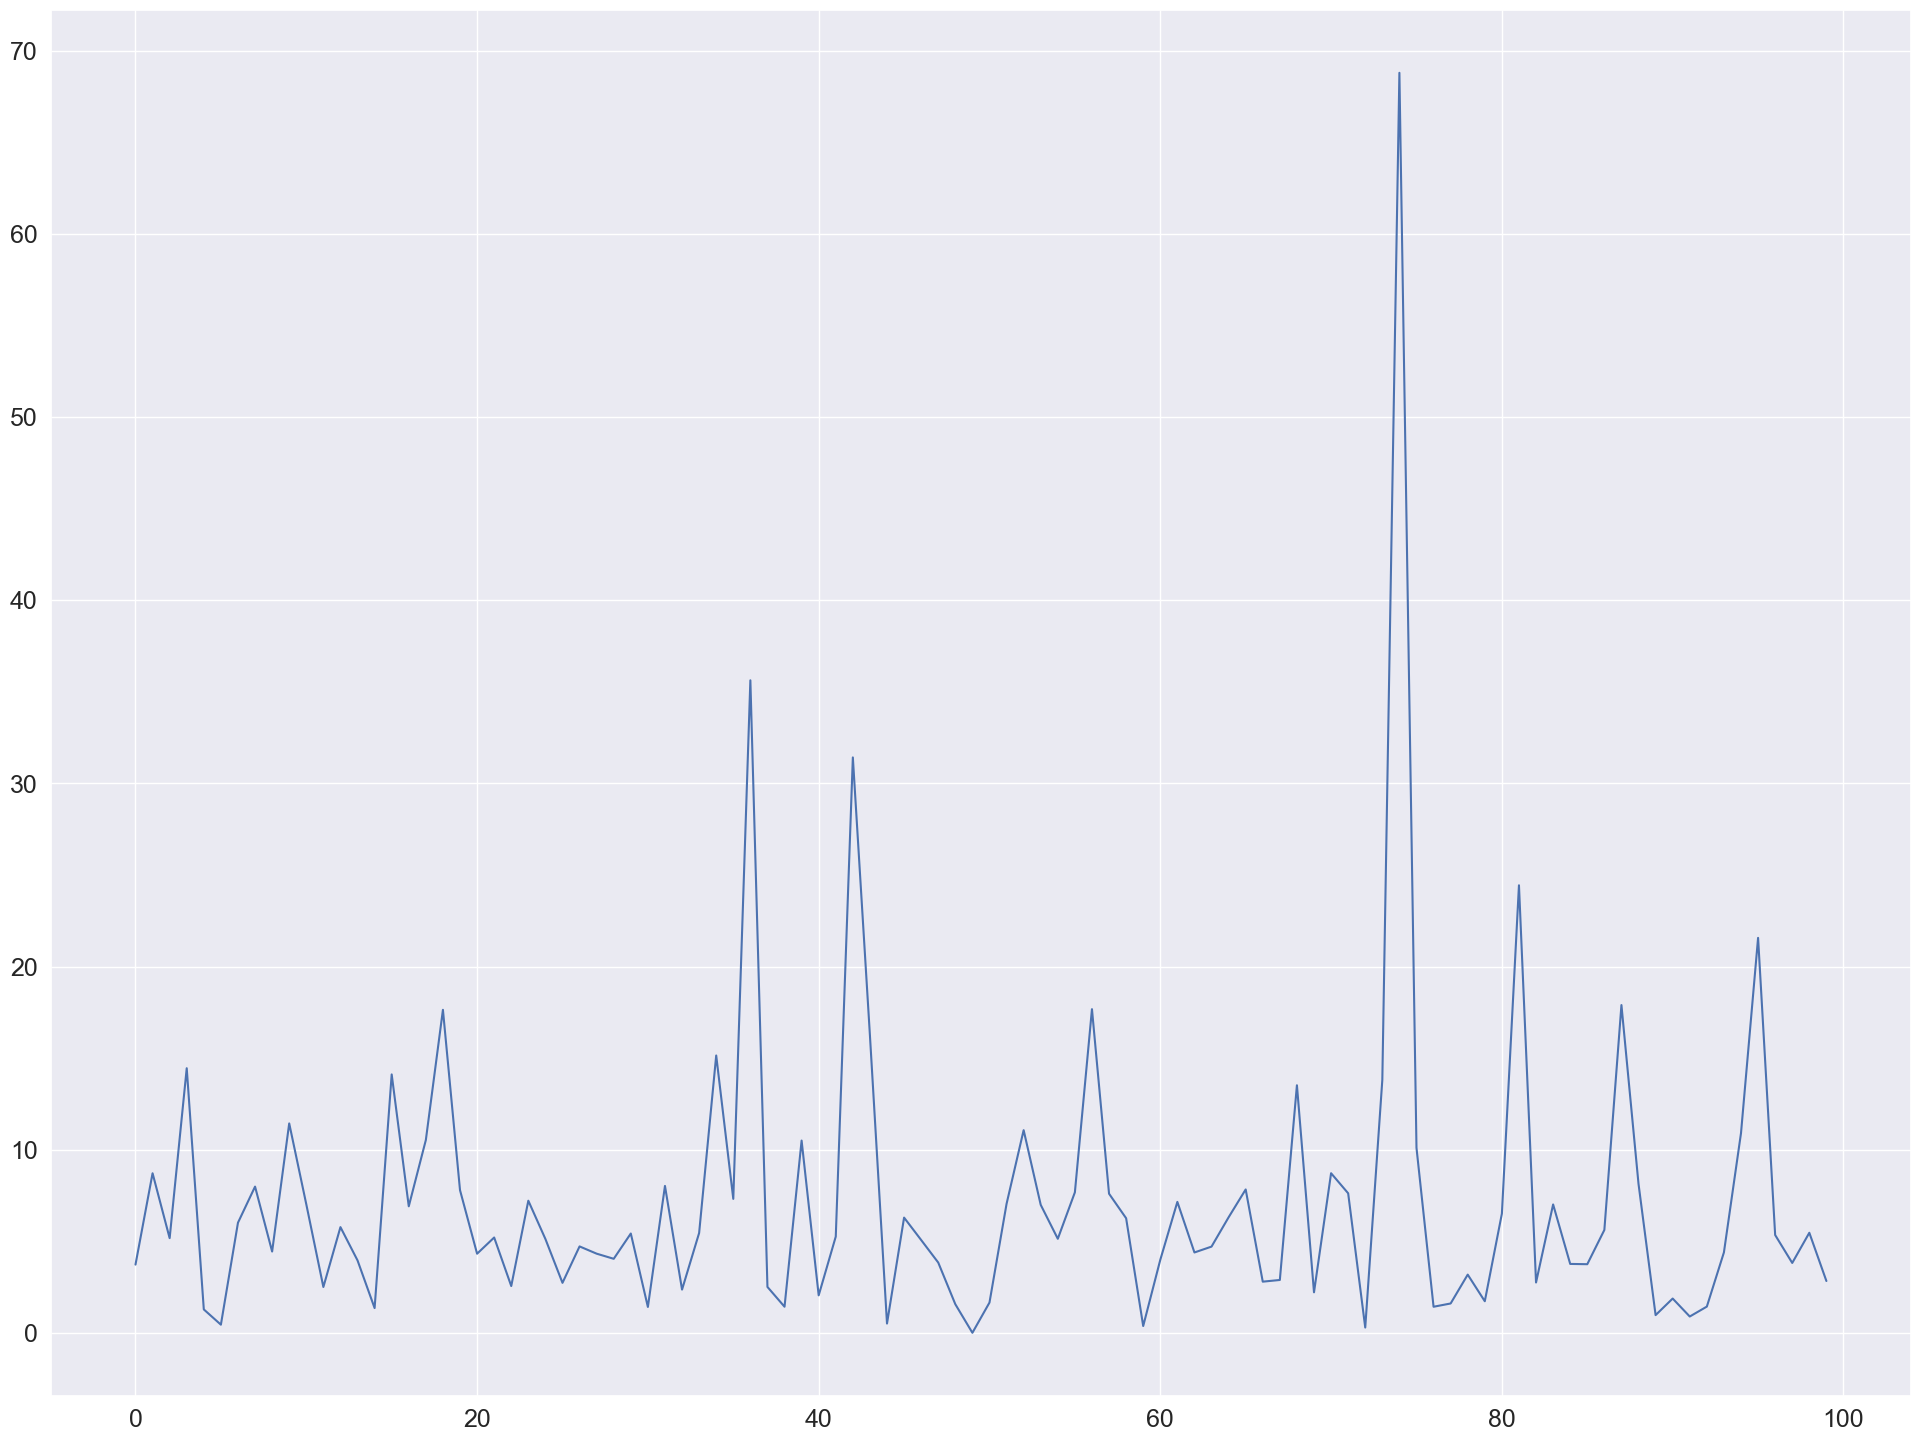

In [9]:
total_loss_list=[]
for i in result:
    total_loss_list.append(i[-1].detach().cpu())
plt.plot(total_loss_list)

In [10]:
result_std=torch.zeros((5,100))
for i in range(len(result)):
    result_std[0,i]=result[i][0].item()
    result_std[1,i]=result[i][1].item()
    result_std[2,i]=result[i][2].item()
    result_std[3,i]=result[i][3].item()
    result_std[4,i]=result[i][4].item()


In [11]:
result_std.std(dim=1)

tensor([3.7440, 0.9989, 0.4206, 0.9355, 4.5909])